In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#drive.flush_and_unmount()

In [3]:
#importing libraries
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import GlobalMaxPooling2D, AveragePooling2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1,l2,l1_l2
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras import regularizers
from keras.callbacks import History,CSVLogger, TensorBoard, ReduceLROnPlateau



In [4]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
#directory_root = 'C:/Users/Baba/Leaf_disease_detection/PlantVillage'
width = 256
height = 256
depth = 3  
bnEps=2e-5
bnMom=0.9
reg=0.0001

In [5]:
# Initialising the CNN
classifier = Sequential()

inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

# Step 1 - Convolution
classifier.add(Conv2D(64, (3, 3), input_shape = inputShape, padding = 'same'))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D())

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), padding = 'same'))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D())

# Adding a third convolutional layer
classifier.add(Conv2D(16, (3, 3), padding = 'same'))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D())


In [6]:
# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 512))
classifier.add(Activation("relu"))

classifier.add(Dense(units = 256))
classifier.add(Activation("relu"))

classifier.add(Dense(units = 128))
classifier.add(Activation("relu"))

classifier.add(Dense(units = 3, activation = 'softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4

In [7]:
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#opt = RMSprop(lr = 1e-4, decay = 1e-6)
# Compiling the CNN
#classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [8]:
# Part 2 - Fitting the CNN to the images



from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=25, width_shift_range=0.1,
                                   height_shift_range=0.1, shear_range=0.2, 
                                   zoom_range=0.2,horizontal_flip=True, 
                                   brightness_range=[0.5, 1.5], channel_shift_range=0.05,
                                   fill_mode="nearest")

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/PLD-80-20-256/Training',
                                                 target_size = (height, width),
                                                 batch_size = BS,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/drive/MyDrive/PLD-80-20-256/Validation',
                                            target_size = (height, width),
                                            batch_size = BS,
                                            class_mode = 'categorical')
print(training_set.samples)

Found 3257 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
3257


In [9]:
# keras model is saved using ModelCheckpoint
# weight is the name of folder
# model is saved with the name 'weights.{epoch:02d}.{accuracy:.4f}.hdf5
# model is saved if the new accuracy is better than previous one
ckpt_callback = ModelCheckpoint(filepath=os.path.join('/content/drive/MyDrive/PDDCNN_PLD_With_Data_Augmentation/weights', 'weights.{epoch:02d}.{accuracy:.4f}.hdf5'), 
                                monitor = 'val_accuracy', save_best_only=True)

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
#early stopping in case the loss stops decreasing

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 10, verbose = 1, min_delta =0.00001)

csvlogger=CSVLogger("/content/drive/MyDrive/PDDCNN_PLD_With_Data_Augmentation/history/training_csv.csv", append=True)


In [10]:
# this is the directory where weights are saved
checkpoint_path = '/content/drive/MyDrive/PDDCNN_PLD_With_Data_Augmentation/weights'

# this is function to load weight file for resuming training from last epoch
def checkpoint_function():
    # if there is no file being saved in the checkpoint path then routine will go to loop model.fit(X, y, epochs=150, batch_size=1, callbacks=[ckpt_callback])
    # this signifies that no file is saved in the checkpoint path and let us begin the training from the first epoch.
    if not os.listdir(checkpoint_path):
        return
    # this loop will fetch epochs number in a list    
    files_int = list()
    for i in os.listdir(checkpoint_path):
        epoch = int(i.split('.')[1])
        files_int.append(epoch)
    # getting the maximum value for an epoch from the list
    # this is reference value and will help to find the file with that value    
    max_value = max(files_int)
    # conditions are applied to find the file which has the maximum value of epoch
    # such file would be the last file where the training is stopped and we would like to resume the training from that point.
    for i in os.listdir(checkpoint_path):
        epoch = int(i.split('.')[1])
        if epoch > max_value:
            pass
        elif epoch < max_value:
            pass
        else:
            final_file = i    
    # in the end we will get the epoch as well as file         
    return final_file, max_value        
            


In [11]:
checkpoint_path_file = checkpoint_function()
# this is interesting loop of the code. Code has been divided into conditions here
# in the if condition if checkpoint is not none, then file and last epcoh is restored
# Such file is loaded using load_model and training start from that epoch
if checkpoint_path_file is not None:
     # Load model:
    checkpoint_path_file = checkpoint_function()[0]
    max_value = checkpoint_function()[1]

    classifier = load_model(os.path.join(checkpoint_path, checkpoint_path_file))
    #model.fit(X, y, epochs=150, batch_size=1, callbacks=[ckpt_callback], initial_epoch = max_value)
    print(max_value)
    history = classifier.fit(training_set,
                         epochs = EPOCHS,
                         initial_epoch = max_value,
                         validation_data = validation_set,
                         callbacks=[ckpt_callback,reduce_lr,csvlogger])
# if there is no checkpoint_path_file it means no file is saved and hence model will be trained from scratch
# file is saved in form of .hdf5 extension 
else:
    #model.fit(X, y, epochs=150, batch_size=1, callbacks=[ckpt_callback])
     history = classifier.fit(training_set,
                         epochs = EPOCHS,
                         validation_data = validation_set,
                         callbacks=[ckpt_callback,reduce_lr,csvlogger])


Epoch 1/100
102/102 [==============================] - 1516s 14s/step - loss: 1.0805 - accuracy: 0.4461 - val_loss: 0.9707 - val_accuracy: 0.5753
Epoch 2/100
 25/102 [======>.......................] - ETA: 47s - loss: 0.9931 - accuracy: 0.5407

KeyboardInterrupt: ignored

In [ ]:
classifier.save("/content/drive/MyDrive/PDDCNN_PLD_With_Data_Augmentation/PDDCNN_PLD_with_Augmentation.h5")
print("Save Model")

Save Model


In [ ]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('PDDCNN Model Loss on PLD Dataset with Data Augmentation')
    ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[1].set_title('PDDCNN Model Accuracy on PLD Dataset with Data Augmentation')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[0].legend()
    ax[1].legend()

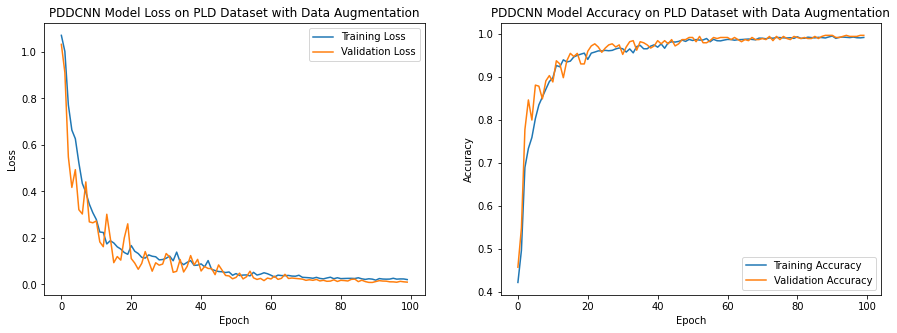

In [ ]:
show_final_history(history)

In [ ]:
a=classifier.evaluate(training_set)
b=classifier.evaluate(test_set)
# c=model.evaluate(x_val,y_val)

print(a)
print(b)
# print(c)
ind=0

13/13 [==============================] - 27s 2s/step - loss: 0.0529 - accuracy: 0.9804
[0.02441033534705639, 0.9914084076881409]
[0.05287071689963341, 0.980440080165863]


In [ ]:
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.Inf
        self.best_map10 = 0

    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')
        map10=logs.get('val_average_precision_at_k10')

        # If BOTH the validation loss AND map10 does not improve for 'patience' epochs, stop training early.
        if np.less(v_loss, self.best_v_loss) and np.greater(map10, self.best_map10):
            self.best_v_loss = v_loss
            self.best_map10 = map10
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [ ]:
model.fit(
    x_train,
    y_train,
    batch_size=64,
    steps_per_epoch=5,
    epochs=30,
    verbose=0,
    callbacks=[CustomEarlyStopping(patience=10)]
)

In [ ]:
from google.colab import files
files.download("model.h5")